DATA

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error

In [122]:
data1 = pd.read_csv("temp+elec2.csv")

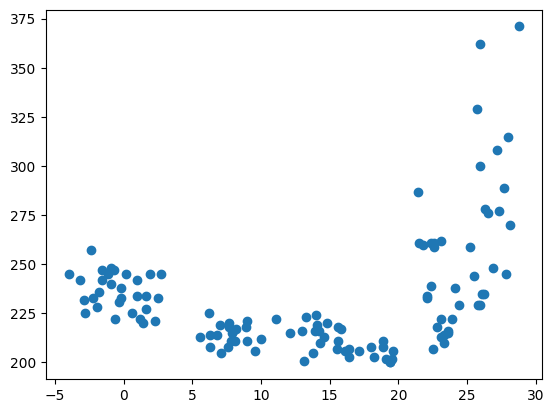

In [123]:
X = data1['ATemp']
y = data1['kWH']

plt.scatter(X,y)
plt.show()

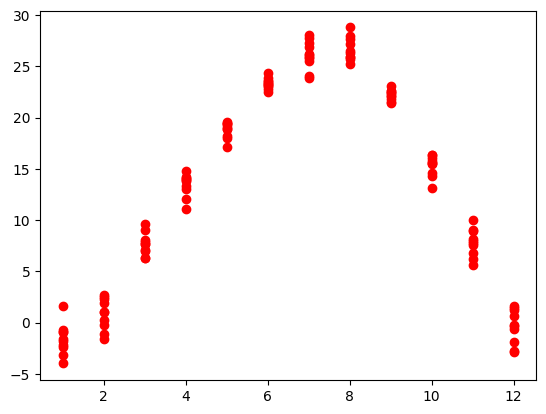

In [124]:
X = data1['month']
y = data1['ATemp']

plt.scatter(X,y,c='red')
plt.show()

ARIMA

In [125]:
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import ndiffs

In [126]:
data2 = data1[0:120]
data = data2.loc[:,["date","kWH"]]
data["date"] = pd.to_datetime(data["date"])

In [127]:
timeseries = data.loc[:,["date","kWH"]]
timeseries.index = timeseries.date
ts=timeseries.drop("date",axis=1)

<Figure size 2000x800 with 0 Axes>

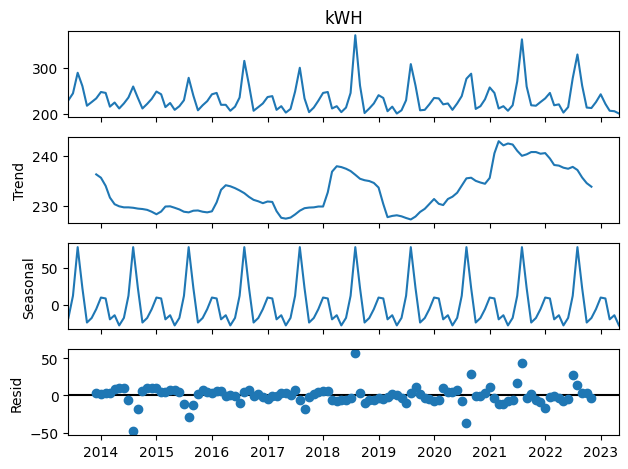

In [128]:
result = seasonal_decompose(ts['kWH'], model='additive')
fig = plt.figure(figsize=(20,8))
fig = result.plot()

In [129]:
data = ts['kWH']
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

model = pm.auto_arima(
            y=data, 
            d=n_diffs, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=12, seasonal=True,
            stepwise=True,
            trace=True
)

추정된 차수 d = 0
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=894.652, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=925.411, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=903.999, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=887.473, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=923.447, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=923.220, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=889.473, Time=0.41 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=889.473, Time=0.55 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=903.590, Time=0.19 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=892.655, Time=0.13 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=889.445, Time=0.28 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=889.443, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=888.235, Time=0.15 sec
 ARIMA(1,0,2)(0,1,1)[12]

In [130]:
train_data, test_data = data[:int(len(data)*0.95)], data[int(len(data)*0.95):]

In [131]:
model_fit = pm.auto_arima(
    	    y=train_data, 
 	        d=0 , 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=12, seasonal=True,
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=847.425, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=876.755, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=857.020, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=841.153, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=874.758, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=874.841, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=843.138, Time=0.38 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=843.127, Time=0.58 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=856.532, Time=0.22 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=845.426, Time=0.11 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=843.042, Time=0.27 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=843.022, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=842.070, Time=0.16 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   

In [132]:
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

Train_MAE: 11.045818432105893
Test_MAE: 6.672050062768648


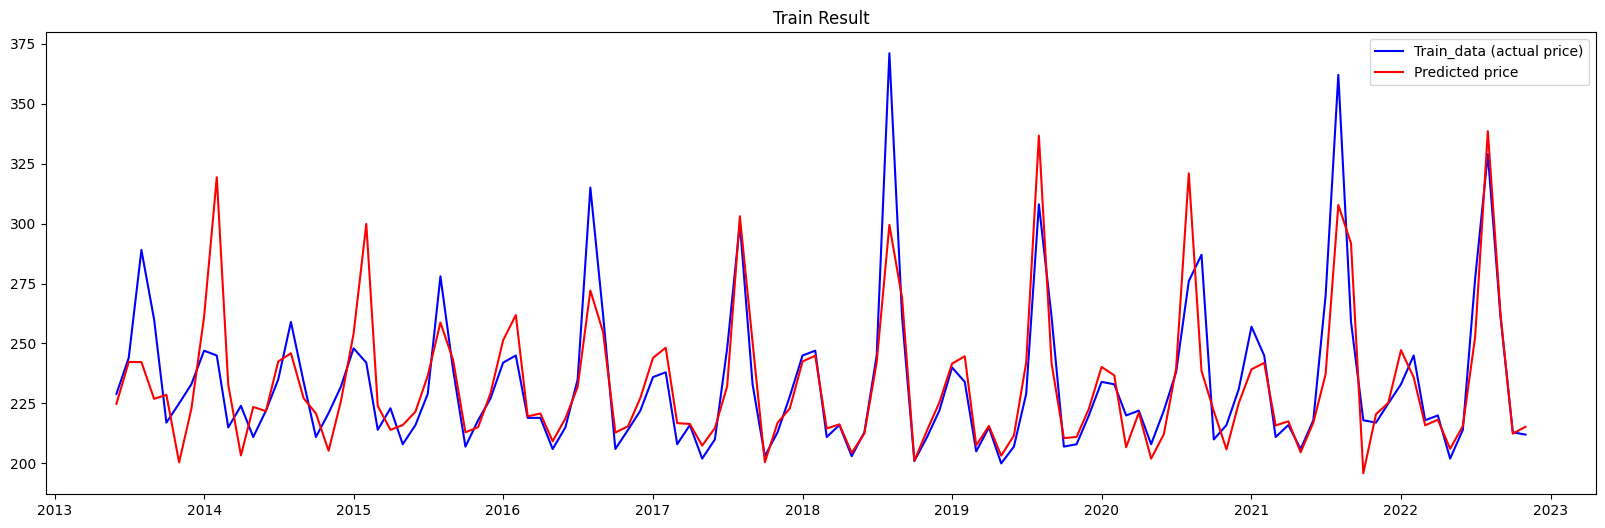

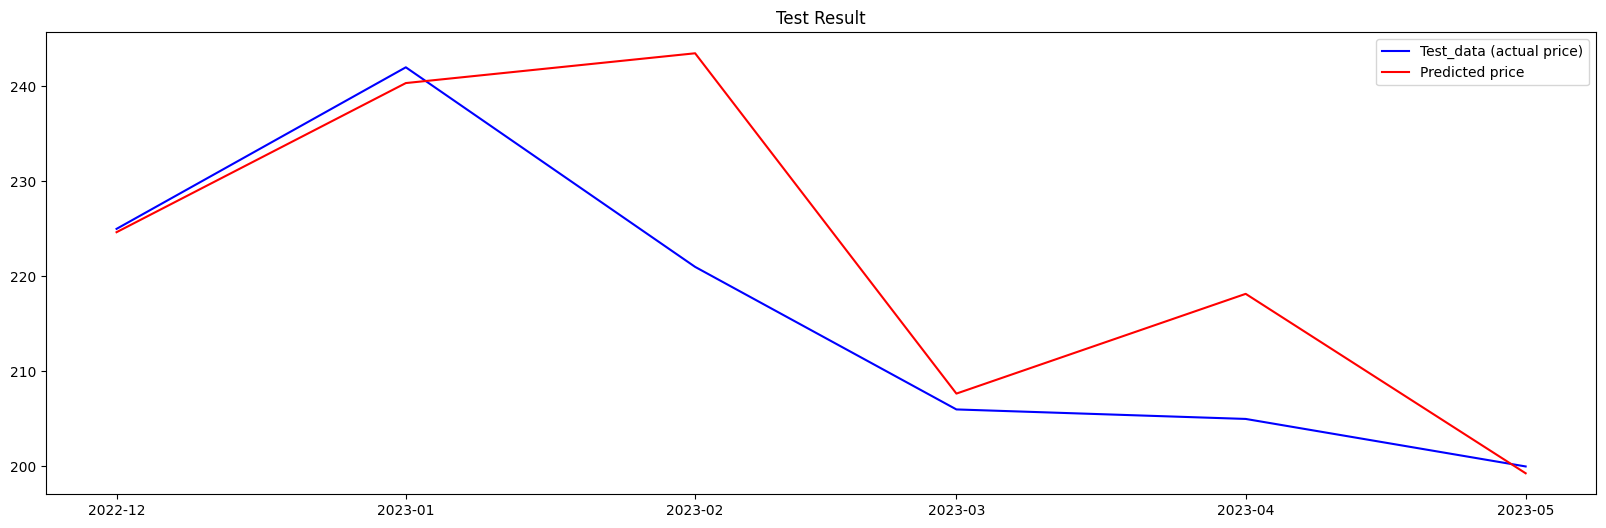

In [133]:
fc_train, upper, lower = forecast(len(train_data), model_fit, train_data.index, data = train_data)

lower_series = pd.Series(lower, index=train_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=train_data.index)  # 예측결과의 상한 바운드

fc_test, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

mae_train = mean_absolute_error(train_data, fc_train)
mae_test = mean_absolute_error(test_data, fc_test)
print("Train_MAE:",mae_train)
print("Test_MAE:",mae_test)

# plt.figure(figsize=(20,6))
# plt.plot(train_data, c='b', label='train_data (actual price)')
# plt.plot(fc_train, c='r',label='predicted price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
# plt.legend(loc='upper left')
# plt.show()

# plt.figure(figsize=(20,6))
# plt.plot(test_data, c='b', label='test_data (actual price)')
# plt.plot(fc, c='r',label='predicted price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
# plt.legend(loc='upper left')
# plt.show()

fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)

ax.plot(train_data, c='b',label='Train_data (actual price)')
ax.plot(fc_train, c='r', label='Predicted price')
ax.legend()
plt.title('Train Result')
plt.show()

fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(test_data, c='b',label='Test_data (actual price)')
ax.plot(fc_test, c='r', label='Predicted price')
ax.legend()
plt.title('Test Result')
plt.show()

In [134]:
pred = model_fit.predict(2,typ='levels')
print(fc_test)
print(pred)

date
2022-12-01    224.648514
2023-01-01    240.341833
2023-02-01    243.476077
2023-03-01    207.666198
2023-04-01    218.162357
2023-05-01    199.281985
dtype: float64
[215.77213427 265.08180998]


In [135]:
pred_to_list = pred.tolist()

LSTM

In [136]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from matplotlib import pyplot as plt
from keras.layers import Dropout

Epoch 1/400
8/8 [==============================] - 4s 4ms/step - loss: 0.1851
Epoch 2/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1523
Epoch 3/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1329
Epoch 4/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1261
Epoch 5/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1234
Epoch 6/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1245
Epoch 7/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1216
Epoch 8/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1236
Epoch 9/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1224
Epoch 10/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1235
Epoch 11/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1230
Epoch 12/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1244
Epoch 13/400
8/8 [==============================] - 0s 3ms/st

8/8 [==============================] - 0s 4ms/step - loss: 0.1171
Epoch 105/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1174
Epoch 106/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1174
Epoch 107/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1172
Epoch 108/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1151
Epoch 109/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1157
Epoch 110/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1163
Epoch 111/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1125
Epoch 112/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1154
Epoch 113/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1159
Epoch 114/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1145
Epoch 115/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1140
Epoch 116/400
8/8 [==============================] - 0

8/8 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 207/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0849
Epoch 208/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0865
Epoch 209/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0875
Epoch 210/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0889
Epoch 211/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0855
Epoch 212/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0858
Epoch 213/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0915
Epoch 214/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0832
Epoch 215/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 216/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0880
Epoch 217/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0921
Epoch 218/400
8/8 [==============================] - 0

8/8 [==============================] - 0s 3ms/step - loss: 0.0836
Epoch 309/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0777
Epoch 310/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0750
Epoch 311/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0873
Epoch 312/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0857
Epoch 313/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0772
Epoch 314/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0808
Epoch 315/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 316/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 317/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0805
Epoch 318/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0801
Epoch 319/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0781
Epoch 320/400
8/8 [==============================] - 0

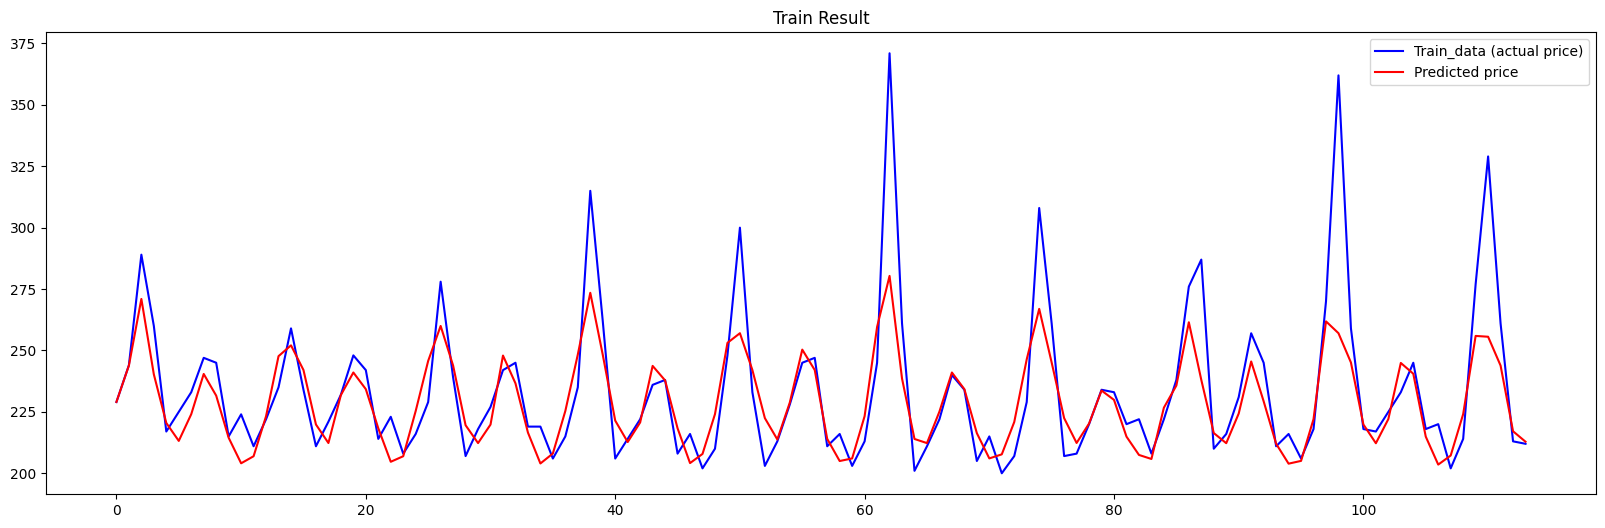

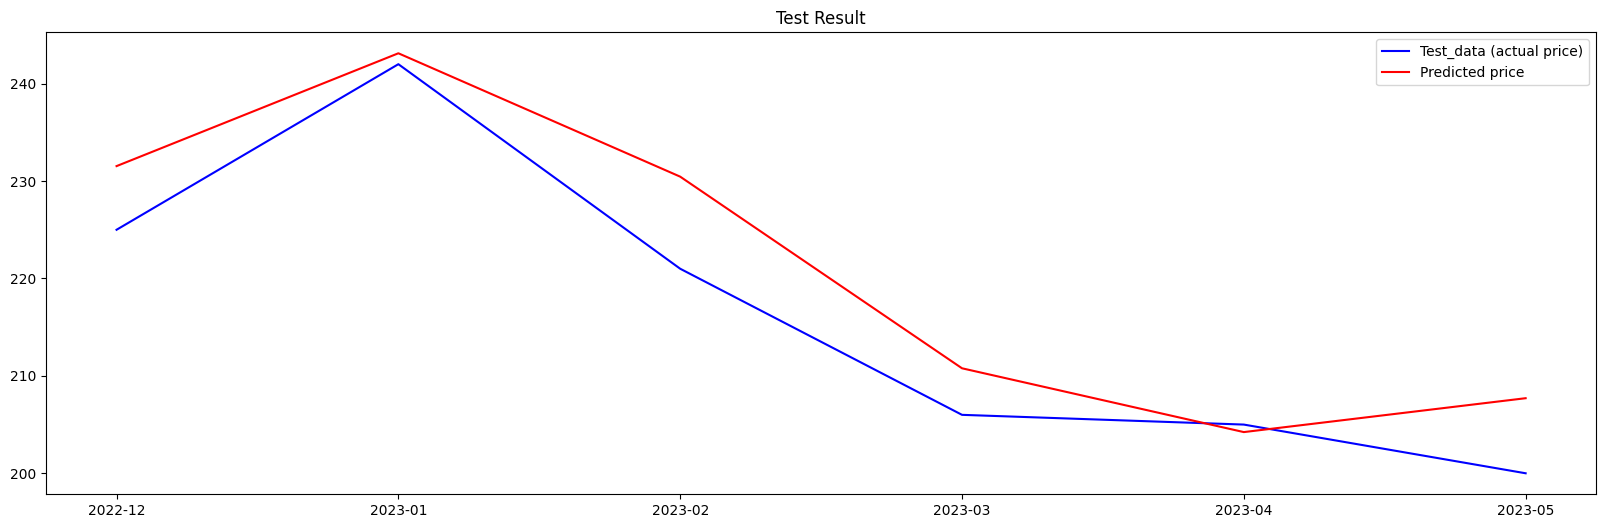

In [146]:
X = data2[['month','ATemp']].values
Y = data2['kWH'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.05, random_state=42,
                                                    shuffle=False)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=400, verbose=1, batch_size=16)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

Y_train_pred = scaler_Y.inverse_transform(Y_train_pred)
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred)
Y_train = scaler_Y.inverse_transform(Y_train)
Y_test = scaler_Y.inverse_transform(Y_test)

train_mae = mean_absolute_error(Y_train, Y_train_pred)
test_mae = mean_absolute_error(Y_test, Y_test_pred)

print('Train MAE: %.9f' % (train_mae))
print('Test MAE: %.9f' % (test_mae))

fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)

ax.plot(Y_train, c='b',label='Train_data (actual price)')
ax.plot(Y_train_pred, c='r', label='Predicted price')
ax.legend()
plt.title('Train Result')
plt.show()
X_plt = ['2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05']
fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(X_plt, Y_test, c='b',label='Test_data (actual price)')
ax.plot(X_plt, Y_test_pred, c='r', label='Predicted price')
ax.legend()
plt.title('Test Result')
plt.show()

In [147]:
new_data=data1[115:122]
X_new = new_data[['month', 'ATemp']].values

X_new_scaled = scaler_X.transform(X_new)

X_new_reshaped = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))

# 예측 수행
Y_new_pred = model.predict(X_new_reshaped)

# 예측 결과를 원래 값으로 스케일링 되돌림
Y_new_pred = scaler_Y.inverse_transform(Y_new_pred)

# 예측 결과 출력
print('Predictions for 2023년:', Y_new_pred)
# fig = plt.figure(facecolor='white', figsize=(20, 10))
# ax = fig.add_subplot(111)
# ax.plot(new_data['kWH'], label='True')
# ax.plot(Y_new_pred, label='Prediction')
# ax.legend()
# plt.title('Test Result')
# plt.show()

1/1 [==============================] - 0s 21ms/step
Predictions for 2023년: [[243.11993]
 [230.45328]
 [210.77936]
 [204.22833]
 [207.70734]
 [224.51224]
 [234.64157]]


MLP

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

Epoch 1/10000
4/4 [==============================] - 1s 3ms/step - loss: 233.6680
Epoch 2/10000
4/4 [==============================] - 0s 2ms/step - loss: 233.5686
Epoch 3/10000
4/4 [==============================] - 0s 2ms/step - loss: 233.4492
Epoch 4/10000
4/4 [==============================] - 0s 3ms/step - loss: 233.2785
Epoch 5/10000
4/4 [==============================] - 0s 3ms/step - loss: 233.0417
Epoch 6/10000
4/4 [==============================] - 0s 2ms/step - loss: 232.7184
Epoch 7/10000
4/4 [==============================] - 0s 3ms/step - loss: 232.2777
Epoch 8/10000
4/4 [==============================] - 0s 2ms/step - loss: 231.6835
Epoch 9/10000
4/4 [==============================] - 0s 4ms/step - loss: 230.8704
Epoch 10/10000
4/4 [==============================] - 0s 2ms/step - loss: 229.8002
Epoch 11/10000
4/4 [==============================] - 0s 3ms/step - loss: 228.3883
Epoch 12/10000
4/4 [==============================] - 0s 4ms/step - loss: 226.5713
Epoch 13/1000

4/4 [==============================] - 0s 3ms/step - loss: 15.1374
Epoch 101/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.0624
Epoch 102/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.1961
Epoch 103/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.0390
Epoch 104/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.0147
Epoch 105/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.1506
Epoch 106/10000
4/4 [==============================] - 0s 2ms/step - loss: 14.9436
Epoch 107/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.4573
Epoch 108/10000
4/4 [==============================] - 0s 3ms/step - loss: 14.9772
Epoch 109/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.2449
Epoch 110/10000
4/4 [==============================] - 0s 2ms/step - loss: 15.0214
Epoch 111/10000
4/4 [==============================] - 0s 2ms/step - loss: 14.9192
Epoch 112/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 13.6169
Epoch 199/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.5705
Epoch 200/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.5719
Epoch 201/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.7002
Epoch 202/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.7177
Epoch 203/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.8518
Epoch 204/10000
4/4 [==============================] - 0s 2ms/step - loss: 14.1463
Epoch 205/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.7320
Epoch 206/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.6997
Epoch 207/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.5533
Epoch 208/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.5576
Epoch 209/10000
4/4 [==============================] - 0s 2ms/step - loss: 13.4019
Epoch 210/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 11.9193
Epoch 297/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.8282
Epoch 298/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.8604
Epoch 299/10000
4/4 [==============================] - 0s 3ms/step - loss: 11.7432
Epoch 300/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.7629
Epoch 301/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.7332
Epoch 302/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.7159
Epoch 303/10000
4/4 [==============================] - 0s 2ms/step - loss: 12.0446
Epoch 304/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.4387
Epoch 305/10000
4/4 [==============================] - 0s 2ms/step - loss: 12.6628
Epoch 306/10000
4/4 [==============================] - 0s 2ms/step - loss: 11.9883
Epoch 307/10000
4/4 [==============================] - 0s 2ms/step - loss: 12.2560
Epoch 308/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 10.0570
Epoch 395/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0546
Epoch 396/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.1096
Epoch 397/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0409
Epoch 398/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0312
Epoch 399/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0978
Epoch 400/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0409
Epoch 401/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.2027
Epoch 402/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.7446
Epoch 403/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.1731
Epoch 404/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.0047
Epoch 405/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.1456
Epoch 406/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 9.4947
Epoch 494/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.7590
Epoch 495/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.6129
Epoch 496/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.6558
Epoch 497/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.6178
Epoch 498/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.9735
Epoch 499/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.5197
Epoch 500/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.7673
Epoch 501/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.6182
Epoch 502/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.5767
Epoch 503/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.5755
Epoch 504/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.7639
Epoch 505/10000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 9.3161
Epoch 594/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.4052
Epoch 595/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.1289
Epoch 596/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.1724
Epoch 597/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.7484
Epoch 598/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.1958
Epoch 599/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.2708
Epoch 600/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.7354
Epoch 601/10000
4/4 [==============================] - 0s 2ms/step - loss: 10.2064
Epoch 602/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.3403
Epoch 603/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.2821
Epoch 604/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.1577
Epoch 605/10000
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 9.0203
Epoch 694/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6892
Epoch 695/10000
4/4 [==============================] - 0s 3ms/step - loss: 9.0850
Epoch 696/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7642
Epoch 697/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.7315
Epoch 698/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.7250
Epoch 699/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.8065
Epoch 700/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7947
Epoch 701/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6461
Epoch 702/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.6711
Epoch 703/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7204
Epoch 704/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7538
Epoch 705/10000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 8.5594
Epoch 794/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6081
Epoch 795/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5886
Epoch 796/10000
4/4 [==============================] - 0s 4ms/step - loss: 8.5092
Epoch 797/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7639
Epoch 798/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.0541
Epoch 799/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6502
Epoch 800/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.8893
Epoch 801/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.1946
Epoch 802/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6548
Epoch 803/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.8479
Epoch 804/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.1700
Epoch 805/10000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 8.5289
Epoch 894/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4811
Epoch 895/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.5405
Epoch 896/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.6280
Epoch 897/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5345
Epoch 898/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5097
Epoch 899/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.6367
Epoch 900/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4891
Epoch 901/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7041
Epoch 902/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.5659
Epoch 903/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4507
Epoch 904/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5468
Epoch 905/10000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 8.3556
Epoch 994/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3713
Epoch 995/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3209
Epoch 996/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2981
Epoch 997/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4414
Epoch 998/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4538
Epoch 999/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.6511
Epoch 1000/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4908
Epoch 1001/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6369
Epoch 1002/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.5238
Epoch 1003/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6053
Epoch 1004/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3577
Epoch 1005/10000
4/4 [=====

Epoch 1092/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5050
Epoch 1093/10000
4/4 [==============================] - 0s 2ms/step - loss: 9.1691
Epoch 1094/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7967
Epoch 1095/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5234
Epoch 1096/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6068
Epoch 1097/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2543
Epoch 1098/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4102
Epoch 1099/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.3280
Epoch 1100/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5564
Epoch 1101/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4503
Epoch 1102/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3713
Epoch 1103/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4634
Epoc

4/4 [==============================] - 0s 6ms/step - loss: 8.2878
Epoch 1191/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2021
Epoch 1192/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.3429
Epoch 1193/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.0583
Epoch 1194/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4014
Epoch 1195/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.7671
Epoch 1196/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4207
Epoch 1197/10000
4/4 [==============================] - 0s 4ms/step - loss: 8.3717
Epoch 1198/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2826
Epoch 1199/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2445
Epoch 1200/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2385
Epoch 1201/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2861
Epoch 1202/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 8.0482
Epoch 1289/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1817
Epoch 1290/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1586
Epoch 1291/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1318
Epoch 1292/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0343
Epoch 1293/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3112
Epoch 1294/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.8048
Epoch 1295/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4407
Epoch 1296/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0819
Epoch 1297/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4956
Epoch 1298/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2439
Epoch 1299/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.1982
Epoch 1300/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 8.0588
Epoch 1387/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0138
Epoch 1388/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0799
Epoch 1389/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0846
Epoch 1390/10000
4/4 [==============================] - 0s 4ms/step - loss: 8.0898
Epoch 1391/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.7256
Epoch 1392/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.8136
Epoch 1393/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1315
Epoch 1394/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2353
Epoch 1395/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.6362
Epoch 1396/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.5319
Epoch 1397/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3229
Epoch 1398/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 8.0501
Epoch 1485/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0328
Epoch 1486/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9178
Epoch 1487/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0939
Epoch 1488/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9238
Epoch 1489/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9434
Epoch 1490/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0231
Epoch 1491/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0995
Epoch 1492/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9283
Epoch 1493/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1210
Epoch 1494/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.8310
Epoch 1495/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4156
Epoch 1496/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.9439
Epoch 1583/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9981
Epoch 1584/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8674
Epoch 1585/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0094
Epoch 1586/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9401
Epoch 1587/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9172
Epoch 1588/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8775
Epoch 1589/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.0327
Epoch 1590/10000
4/4 [==============================] - 0s 4ms/step - loss: 8.2267
Epoch 1591/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8872
Epoch 1592/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9869
Epoch 1593/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2378
Epoch 1594/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.9104
Epoch 1681/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0293
Epoch 1682/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.1074
Epoch 1683/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9626
Epoch 1684/10000
4/4 [==============================] - 0s 4ms/step - loss: 8.0204
Epoch 1685/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2330
Epoch 1686/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2119
Epoch 1687/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0216
Epoch 1688/10000
4/4 [==============================] - 0s 6ms/step - loss: 8.1670
Epoch 1689/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9065
Epoch 1690/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.8531
Epoch 1691/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8948
Epoch 1692/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.8693
Epoch 1779/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0417
Epoch 1780/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8635
Epoch 1781/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7621
Epoch 1782/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9448
Epoch 1783/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7900
Epoch 1784/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9632
Epoch 1785/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1201
Epoch 1786/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9404
Epoch 1787/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9999
Epoch 1788/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1069
Epoch 1789/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9168
Epoch 1790/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.8310
Epoch 1877/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8434
Epoch 1878/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9038
Epoch 1879/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7243
Epoch 1880/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7494
Epoch 1881/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7524
Epoch 1882/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7374
Epoch 1883/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.7236
Epoch 1884/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.0614
Epoch 1885/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8462
Epoch 1886/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7482
Epoch 1887/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7287
Epoch 1888/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.9365
Epoch 1975/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7341
Epoch 1976/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9957
Epoch 1977/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.1226
Epoch 1978/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7281
Epoch 1979/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0144
Epoch 1980/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8747
Epoch 1981/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9094
Epoch 1982/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8513
Epoch 1983/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6940
Epoch 1984/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9675
Epoch 1985/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2551
Epoch 1986/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.9022
Epoch 2073/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8498
Epoch 2074/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6356
Epoch 2075/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6801
Epoch 2076/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6934
Epoch 2077/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8945
Epoch 2078/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6720
Epoch 2079/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8447
Epoch 2080/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0368
Epoch 2081/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9020
Epoch 2082/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.2274
Epoch 2083/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8401
Epoch 2084/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6382
Epoch 2171/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9614
Epoch 2172/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8564
Epoch 2173/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0214
Epoch 2174/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7979
Epoch 2175/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.8010
Epoch 2176/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8325
Epoch 2177/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7966
Epoch 2178/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6705
Epoch 2179/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6149
Epoch 2180/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6528
Epoch 2181/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6032
Epoch 2182/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.7533
Epoch 2269/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6676
Epoch 2270/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6417
Epoch 2271/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7358
Epoch 2272/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6119
Epoch 2273/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8462
Epoch 2274/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0870
Epoch 2275/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0164
Epoch 2276/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4838
Epoch 2277/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9748
Epoch 2278/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6762
Epoch 2279/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0474
Epoch 2280/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6472
Epoch 2367/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0752
Epoch 2368/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8009
Epoch 2369/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7008
Epoch 2370/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8929
Epoch 2371/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6442
Epoch 2372/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7393
Epoch 2373/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1366
Epoch 2374/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0524
Epoch 2375/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6627
Epoch 2376/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6377
Epoch 2377/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0534
Epoch 2378/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5826
Epoch 2465/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7022
Epoch 2466/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7174
Epoch 2467/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5010
Epoch 2468/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6709
Epoch 2469/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6961
Epoch 2470/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6566
Epoch 2471/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6379
Epoch 2472/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5793
Epoch 2473/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5617
Epoch 2474/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6137
Epoch 2475/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6556
Epoch 2476/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6620
Epoch 2563/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7022
Epoch 2564/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5604
Epoch 2565/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6015
Epoch 2566/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5416
Epoch 2567/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6076
Epoch 2568/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5730
Epoch 2569/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6693
Epoch 2570/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5038
Epoch 2571/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5723
Epoch 2572/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8496
Epoch 2573/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6336
Epoch 2574/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.8716
Epoch 2661/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7046
Epoch 2662/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0186
Epoch 2663/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7206
Epoch 2664/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8907
Epoch 2665/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7844
Epoch 2666/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8561
Epoch 2667/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6272
Epoch 2668/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6843
Epoch 2669/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8070
Epoch 2670/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.5715
Epoch 2671/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6221
Epoch 2672/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6095
Epoch 2759/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8368
Epoch 2760/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4934
Epoch 2761/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7426
Epoch 2762/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6074
Epoch 2763/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7929
Epoch 2764/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6911
Epoch 2765/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6368
Epoch 2766/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9334
Epoch 2767/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7310
Epoch 2768/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6201
Epoch 2769/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7459
Epoch 2770/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6572
Epoch 2857/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8548
Epoch 2858/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5820
Epoch 2859/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5197
Epoch 2860/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.9273
Epoch 2861/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4837
Epoch 2862/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7789
Epoch 2863/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8288
Epoch 2864/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8299
Epoch 2865/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5238
Epoch 2866/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5859
Epoch 2867/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5138
Epoch 2868/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.8022
Epoch 2955/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5139
Epoch 2956/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.5046
Epoch 2957/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7032
Epoch 2958/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4347
Epoch 2959/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5499
Epoch 2960/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6120
Epoch 2961/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5555
Epoch 2962/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.1152
Epoch 2963/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5898
Epoch 2964/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6895
Epoch 2965/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6251
Epoch 2966/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.7770
Epoch 3053/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6339
Epoch 3054/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3889
Epoch 3055/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4929
Epoch 3056/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4417
Epoch 3057/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5955
Epoch 3058/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4445
Epoch 3059/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5063
Epoch 3060/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4170
Epoch 3061/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5423
Epoch 3062/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4021
Epoch 3063/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5185
Epoch 3064/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5365
Epoch 3151/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5419
Epoch 3152/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9474
Epoch 3153/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5214
Epoch 3154/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7337
Epoch 3155/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4170
Epoch 3156/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5721
Epoch 3157/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7696
Epoch 3158/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7806
Epoch 3159/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.1350
Epoch 3160/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5947
Epoch 3161/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6658
Epoch 3162/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.9084
Epoch 3249/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.3158
Epoch 3250/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2881
Epoch 3251/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7484
Epoch 3252/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6914
Epoch 3253/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4346
Epoch 3254/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8611
Epoch 3255/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6545
Epoch 3256/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5696
Epoch 3257/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9969
Epoch 3258/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5751
Epoch 3259/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7540
Epoch 3260/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3730
Epoch 3347/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4227
Epoch 3348/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4892
Epoch 3349/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5686
Epoch 3350/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4705
Epoch 3351/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3284
Epoch 3352/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3542
Epoch 3353/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3408
Epoch 3354/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4213
Epoch 3355/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4974
Epoch 3356/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3217
Epoch 3357/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5599
Epoch 3358/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5068
Epoch 3445/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7221
Epoch 3446/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4565
Epoch 3447/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5535
Epoch 3448/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3761
Epoch 3449/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4001
Epoch 3450/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5198
Epoch 3451/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2765
Epoch 3452/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4029
Epoch 3453/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4168
Epoch 3454/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4785
Epoch 3455/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4065
Epoch 3456/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.6785
Epoch 3543/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5628
Epoch 3544/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5235
Epoch 3545/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5316
Epoch 3546/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.9774
Epoch 3547/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2397
Epoch 3548/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2524
Epoch 3549/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.1958
Epoch 3550/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0050
Epoch 3551/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8843
Epoch 3552/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8607
Epoch 3553/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6558
Epoch 3554/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2584
Epoch 3641/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2372
Epoch 3642/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3070
Epoch 3643/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3956
Epoch 3644/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4427
Epoch 3645/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4394
Epoch 3646/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2185
Epoch 3647/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5388
Epoch 3648/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3011
Epoch 3649/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2913
Epoch 3650/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3487
Epoch 3651/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2291
Epoch 3652/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.6384
Epoch 3739/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4808
Epoch 3740/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4425
Epoch 3741/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4142
Epoch 3742/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5263
Epoch 3743/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4979
Epoch 3744/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5314
Epoch 3745/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2756
Epoch 3746/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4614
Epoch 3747/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3781
Epoch 3748/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3333
Epoch 3749/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2803
Epoch 3750/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2862
Epoch 3837/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2674
Epoch 3838/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2543
Epoch 3839/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3616
Epoch 3840/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6651
Epoch 3841/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5824
Epoch 3842/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6614
Epoch 3843/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7739
Epoch 3844/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7240
Epoch 3845/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4147
Epoch 3846/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.6306
Epoch 3847/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7880
Epoch 3848/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2738
Epoch 3935/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4007
Epoch 3936/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4541
Epoch 3937/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5482
Epoch 3938/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6385
Epoch 3939/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4966
Epoch 3940/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5870
Epoch 3941/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4055
Epoch 3942/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2937
Epoch 3943/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7304
Epoch 3944/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4748
Epoch 3945/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2995
Epoch 3946/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3919
Epoch 4033/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4274
Epoch 4034/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.5088
Epoch 4035/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2895
Epoch 4036/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2087
Epoch 4037/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3206
Epoch 4038/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3531
Epoch 4039/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3084
Epoch 4040/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5291
Epoch 4041/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3122
Epoch 4042/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4048
Epoch 4043/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4290
Epoch 4044/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.4924
Epoch 4131/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0666
Epoch 4132/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3259
Epoch 4133/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2296
Epoch 4134/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2247
Epoch 4135/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4272
Epoch 4136/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1390
Epoch 4137/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3227
Epoch 4138/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2405
Epoch 4139/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3903
Epoch 4140/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1773
Epoch 4141/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2930
Epoch 4142/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.2379
Epoch 4229/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4856
Epoch 4230/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4088
Epoch 4231/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1843
Epoch 4232/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1195
Epoch 4233/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2447
Epoch 4234/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3752
Epoch 4235/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3296
Epoch 4236/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4453
Epoch 4237/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.3866
Epoch 4238/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3511
Epoch 4239/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1724
Epoch 4240/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3230
Epoch 4327/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1606
Epoch 4328/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2007
Epoch 4329/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2325
Epoch 4330/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3232
Epoch 4331/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2740
Epoch 4332/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4466
Epoch 4333/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3514
Epoch 4334/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0930
Epoch 4335/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3002
Epoch 4336/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4092
Epoch 4337/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.4878
Epoch 4338/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.4618
Epoch 4425/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8580
Epoch 4426/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5389
Epoch 4427/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3402
Epoch 4428/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7835
Epoch 4429/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3819
Epoch 4430/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3121
Epoch 4431/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6150
Epoch 4432/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4542
Epoch 4433/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6267
Epoch 4434/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0028
Epoch 4435/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5089
Epoch 4436/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2839
Epoch 4523/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3938
Epoch 4524/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.4014
Epoch 4525/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6743
Epoch 4526/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2910
Epoch 4527/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8502
Epoch 4528/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.3998
Epoch 4529/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.1296
Epoch 4530/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3011
Epoch 4531/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2750
Epoch 4532/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2139
Epoch 4533/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.2239
Epoch 4534/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2431
Epoch 4621/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0728
Epoch 4622/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2931
Epoch 4623/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1483
Epoch 4624/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5740
Epoch 4625/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0166
Epoch 4626/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4585
Epoch 4627/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3253
Epoch 4628/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4705
Epoch 4629/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3160
Epoch 4630/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3743
Epoch 4631/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2632
Epoch 4632/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0521
Epoch 4719/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3241
Epoch 4720/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1320
Epoch 4721/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5011
Epoch 4722/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3006
Epoch 4723/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3015
Epoch 4724/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5908
Epoch 4725/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2212
Epoch 4726/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4970
Epoch 4727/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1905
Epoch 4728/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1477
Epoch 4729/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2022
Epoch 4730/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.1742
Epoch 4817/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2162
Epoch 4818/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0510
Epoch 4819/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3621
Epoch 4820/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2990
Epoch 4821/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4839
Epoch 4822/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1468
Epoch 4823/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3430
Epoch 4824/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3780
Epoch 4825/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2593
Epoch 4826/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4114
Epoch 4827/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2969
Epoch 4828/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.7733
Epoch 4915/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9635
Epoch 4916/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6441
Epoch 4917/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3340
Epoch 4918/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1138
Epoch 4919/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2596
Epoch 4920/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1946
Epoch 4921/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1839
Epoch 4922/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1269
Epoch 4923/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2117
Epoch 4924/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0855
Epoch 4925/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1058
Epoch 4926/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.7134
Epoch 5013/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7212
Epoch 5014/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1352
Epoch 5015/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4374
Epoch 5016/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3482
Epoch 5017/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3476
Epoch 5018/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.2094
Epoch 5019/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2587
Epoch 5020/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4855
Epoch 5021/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0851
Epoch 5022/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1881
Epoch 5023/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4334
Epoch 5024/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5218
Epoch 5111/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3945
Epoch 5112/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1783
Epoch 5113/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3144
Epoch 5114/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.4539
Epoch 5115/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4063
Epoch 5116/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7582
Epoch 5117/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.9538
Epoch 5118/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9561
Epoch 5119/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4622
Epoch 5120/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7161
Epoch 5121/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7269
Epoch 5122/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.9590
Epoch 5209/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4231
Epoch 5210/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.9727
Epoch 5211/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.0166
Epoch 5212/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7417
Epoch 5213/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6467
Epoch 5214/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5838
Epoch 5215/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1516
Epoch 5216/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0690
Epoch 5217/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0352
Epoch 5218/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0750
Epoch 5219/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0554
Epoch 5220/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.0208
Epoch 5307/10000
4/4 [==============================] - 0s 4ms/step - loss: 6.9889
Epoch 5308/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2096
Epoch 5309/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0822
Epoch 5310/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1481
Epoch 5311/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1658
Epoch 5312/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.1425
Epoch 5313/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9671
Epoch 5314/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1499
Epoch 5315/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2085
Epoch 5316/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4083
Epoch 5317/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2582
Epoch 5318/10000
4/4

4/4 [==============================] - 0s 2ms/step - loss: 7.2209
Epoch 5405/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2247
Epoch 5406/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1530
Epoch 5407/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0836
Epoch 5408/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3425
Epoch 5409/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1823
Epoch 5410/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1148
Epoch 5411/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1644
Epoch 5412/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1109
Epoch 5413/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0774
Epoch 5414/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1184
Epoch 5415/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3207
Epoch 5416/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0770
Epoch 5503/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1224
Epoch 5504/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0392
Epoch 5505/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1164
Epoch 5506/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2386
Epoch 5507/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3887
Epoch 5508/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1088
Epoch 5509/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1179
Epoch 5510/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2961
Epoch 5511/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5290
Epoch 5512/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0674
Epoch 5513/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1347
Epoch 5514/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.8675
Epoch 5601/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2862
Epoch 5602/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5602
Epoch 5603/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5615
Epoch 5604/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6180
Epoch 5605/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1874
Epoch 5606/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4528
Epoch 5607/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1630
Epoch 5608/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0535
Epoch 5609/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0771
Epoch 5610/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7781
Epoch 5611/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3111
Epoch 5612/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.1205
Epoch 5699/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1227
Epoch 5700/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0542
Epoch 5701/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1870
Epoch 5702/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1155
Epoch 5703/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2958
Epoch 5704/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9359
Epoch 5705/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4082
Epoch 5706/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1728
Epoch 5707/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9585
Epoch 5708/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2255
Epoch 5709/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0233
Epoch 5710/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.1118
Epoch 5797/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0320
Epoch 5798/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1605
Epoch 5799/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0971
Epoch 5800/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0781
Epoch 5801/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9333
Epoch 5802/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9684
Epoch 5803/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0372
Epoch 5804/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2036
Epoch 5805/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.0217
Epoch 5806/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1514
Epoch 5807/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0024
Epoch 5808/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3177
Epoch 5895/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1353
Epoch 5896/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2301
Epoch 5897/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2623
Epoch 5898/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3036
Epoch 5899/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2697
Epoch 5900/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3297
Epoch 5901/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1208
Epoch 5902/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2809
Epoch 5903/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2138
Epoch 5904/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2066
Epoch 5905/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3576
Epoch 5906/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.4333
Epoch 5993/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0906
Epoch 5994/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1098
Epoch 5995/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0443
Epoch 5996/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3038
Epoch 5997/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4275
Epoch 5998/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8451
Epoch 5999/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2374
Epoch 6000/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5320
Epoch 6001/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3280
Epoch 6002/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2792
Epoch 6003/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1346
Epoch 6004/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5059
Epoch 6091/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0835
Epoch 6092/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1221
Epoch 6093/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0412
Epoch 6094/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1250
Epoch 6095/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0482
Epoch 6096/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0938
Epoch 6097/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0656
Epoch 6098/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9769
Epoch 6099/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0542
Epoch 6100/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0322
Epoch 6101/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5269
Epoch 6102/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5071
Epoch 6189/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5230
Epoch 6190/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0053
Epoch 6191/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.3583
Epoch 6192/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3265
Epoch 6193/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6172
Epoch 6194/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0133
Epoch 6195/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2402
Epoch 6196/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3263
Epoch 6197/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2442
Epoch 6198/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1468
Epoch 6199/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1467
Epoch 6200/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3155
Epoch 6287/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2259
Epoch 6288/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7270
Epoch 6289/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3802
Epoch 6290/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5174
Epoch 6291/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0648
Epoch 6292/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2600
Epoch 6293/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1375
Epoch 6294/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9905
Epoch 6295/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1651
Epoch 6296/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1362
Epoch 6297/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6507
Epoch 6298/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3848
Epoch 6385/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6317
Epoch 6386/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1983
Epoch 6387/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1906
Epoch 6388/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1001
Epoch 6389/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4590
Epoch 6390/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3841
Epoch 6391/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1502
Epoch 6392/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3104
Epoch 6393/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0986
Epoch 6394/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2244
Epoch 6395/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0516
Epoch 6396/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0810
Epoch 6483/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1438
Epoch 6484/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3211
Epoch 6485/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1838
Epoch 6486/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1235
Epoch 6487/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0613
Epoch 6488/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0064
Epoch 6489/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0581
Epoch 6490/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0094
Epoch 6491/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1302
Epoch 6492/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0124
Epoch 6493/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1229
Epoch 6494/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.1112
Epoch 6581/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0371
Epoch 6582/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1107
Epoch 6583/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1187
Epoch 6584/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2566
Epoch 6585/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0521
Epoch 6586/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3733
Epoch 6587/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1214
Epoch 6588/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2727
Epoch 6589/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1252
Epoch 6590/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2819
Epoch 6591/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2979
Epoch 6592/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9390
Epoch 6679/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9849
Epoch 6680/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3973
Epoch 6681/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0874
Epoch 6682/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5570
Epoch 6683/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.8419
Epoch 6684/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1264
Epoch 6685/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1807
Epoch 6686/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3926
Epoch 6687/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7338
Epoch 6688/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7819
Epoch 6689/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7393
Epoch 6690/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.2480
Epoch 6777/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0152
Epoch 6778/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2134
Epoch 6779/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0693
Epoch 6780/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3714
Epoch 6781/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1305
Epoch 6782/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9644
Epoch 6783/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3499
Epoch 6784/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0192
Epoch 6785/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3654
Epoch 6786/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4072
Epoch 6787/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0414
Epoch 6788/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9984
Epoch 6875/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2174
Epoch 6876/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1404
Epoch 6877/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0099
Epoch 6878/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.1556
Epoch 6879/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2413
Epoch 6880/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1158
Epoch 6881/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5631
Epoch 6882/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.8842
Epoch 6883/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5092
Epoch 6884/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0065
Epoch 6885/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3310
Epoch 6886/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2243
Epoch 6973/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0576
Epoch 6974/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9913
Epoch 6975/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9241
Epoch 6976/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1671
Epoch 6977/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1431
Epoch 6978/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6124
Epoch 6979/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.7102
Epoch 6980/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5801
Epoch 6981/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6243
Epoch 6982/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0926
Epoch 6983/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3137
Epoch 6984/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.1753
Epoch 7071/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1569
Epoch 7072/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9534
Epoch 7073/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0681
Epoch 7074/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9967
Epoch 7075/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2407
Epoch 7076/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9911
Epoch 7077/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2001
Epoch 7078/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1886
Epoch 7079/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2663
Epoch 7080/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0083
Epoch 7081/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0087
Epoch 7082/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.8674
Epoch 7169/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2813
Epoch 7170/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4370
Epoch 7171/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5034
Epoch 7172/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2858
Epoch 7173/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4827
Epoch 7174/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1820
Epoch 7175/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9995
Epoch 7176/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0048
Epoch 7177/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9460
Epoch 7178/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2021
Epoch 7179/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9992
Epoch 7180/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.0155
Epoch 7267/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1040
Epoch 7268/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1249
Epoch 7269/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2236
Epoch 7270/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1011
Epoch 7271/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0714
Epoch 7272/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0247
Epoch 7273/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0357
Epoch 7274/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1597
Epoch 7275/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0576
Epoch 7276/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2887
Epoch 7277/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0967
Epoch 7278/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2812
Epoch 7365/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5058
Epoch 7366/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9737
Epoch 7367/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0860
Epoch 7368/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9790
Epoch 7369/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9618
Epoch 7370/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9501
Epoch 7371/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9644
Epoch 7372/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.0559
Epoch 7373/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0874
Epoch 7374/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4041
Epoch 7375/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3450
Epoch 7376/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2078
Epoch 7463/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1741
Epoch 7464/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9625
Epoch 7465/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0952
Epoch 7466/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1110
Epoch 7467/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0199
Epoch 7468/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4066
Epoch 7469/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2743
Epoch 7470/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.4868
Epoch 7471/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.3241
Epoch 7472/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5127
Epoch 7473/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1002
Epoch 7474/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9636
Epoch 7561/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1484
Epoch 7562/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1188
Epoch 7563/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1090
Epoch 7564/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9883
Epoch 7565/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1332
Epoch 7566/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1991
Epoch 7567/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4886
Epoch 7568/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4885
Epoch 7569/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5999
Epoch 7570/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8101
Epoch 7571/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2772
Epoch 7572/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0405
Epoch 7659/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1390
Epoch 7660/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0993
Epoch 7661/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1249
Epoch 7662/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3097
Epoch 7663/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2453
Epoch 7664/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1922
Epoch 7665/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2769
Epoch 7666/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1156
Epoch 7667/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0313
Epoch 7668/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0747
Epoch 7669/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1063
Epoch 7670/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0547
Epoch 7757/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9643
Epoch 7758/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1774
Epoch 7759/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0475
Epoch 7760/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9664
Epoch 7761/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.0005
Epoch 7762/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0302
Epoch 7763/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1062
Epoch 7764/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0163
Epoch 7765/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0031
Epoch 7766/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1414
Epoch 7767/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.2225
Epoch 7768/10000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 7.3466
Epoch 7855/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3097
Epoch 7856/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4443
Epoch 7857/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3063
Epoch 7858/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1028
Epoch 7859/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0129
Epoch 7860/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1381
Epoch 7861/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4791
Epoch 7862/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0593
Epoch 7863/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0347
Epoch 7864/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0907
Epoch 7865/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2322
Epoch 7866/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5183
Epoch 7953/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8465
Epoch 7954/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.2170
Epoch 7955/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2331
Epoch 7956/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2240
Epoch 7957/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4297
Epoch 7958/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0874
Epoch 7959/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2725
Epoch 7960/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0000
Epoch 7961/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2103
Epoch 7962/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9787
Epoch 7963/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2401
Epoch 7964/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.2630
Epoch 8051/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5401
Epoch 8052/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3577
Epoch 8053/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3423
Epoch 8054/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1610
Epoch 8055/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3111
Epoch 8056/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1027
Epoch 8057/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1610
Epoch 8058/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1096
Epoch 8059/10000
4/4 [==============================] - 0s 6ms/step - loss: 7.2752
Epoch 8060/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0474
Epoch 8061/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1629
Epoch 8062/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 6.9281
Epoch 8149/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0355
Epoch 8150/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2523
Epoch 8151/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0958
Epoch 8152/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2427
Epoch 8153/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2321
Epoch 8154/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.8802
Epoch 8155/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4494
Epoch 8156/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4536
Epoch 8157/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3128
Epoch 8158/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.3563
Epoch 8159/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4029
Epoch 8160/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9256
Epoch 8247/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1647
Epoch 8248/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0155
Epoch 8249/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9545
Epoch 8250/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0203
Epoch 8251/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1919
Epoch 8252/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9598
Epoch 8253/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9468
Epoch 8254/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9648
Epoch 8255/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0399
Epoch 8256/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3303
Epoch 8257/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1246
Epoch 8258/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3390
Epoch 8345/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9606
Epoch 8346/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.2934
Epoch 8347/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4877
Epoch 8348/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3188
Epoch 8349/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.0739
Epoch 8350/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.0978
Epoch 8351/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.2581
Epoch 8352/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3116
Epoch 8353/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.0158
Epoch 8354/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3977
Epoch 8355/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0591
Epoch 8356/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0794
Epoch 8443/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9710
Epoch 8444/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0418
Epoch 8445/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0300
Epoch 8446/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0342
Epoch 8447/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2388
Epoch 8448/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2095
Epoch 8449/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0911
Epoch 8450/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3736
Epoch 8451/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3089
Epoch 8452/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2833
Epoch 8453/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0954
Epoch 8454/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.3584
Epoch 8541/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2538
Epoch 8542/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9984
Epoch 8543/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5120
Epoch 8544/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2303
Epoch 8545/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0647
Epoch 8546/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5045
Epoch 8547/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.9157
Epoch 8548/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3657
Epoch 8549/10000
4/4 [==============================] - 0s 3ms/step - loss: 8.0331
Epoch 8550/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.7297
Epoch 8551/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0116
Epoch 8552/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.2149
Epoch 8639/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9936
Epoch 8640/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0583
Epoch 8641/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1631
Epoch 8642/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3330
Epoch 8643/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.0973
Epoch 8644/10000
4/4 [==============================] - 0s 4ms/step - loss: 6.9558
Epoch 8645/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1250
Epoch 8646/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.0604
Epoch 8647/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9973
Epoch 8648/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9162
Epoch 8649/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.0923
Epoch 8650/10000
4/4

4/4 [==============================] - 0s 2ms/step - loss: 7.3778
Epoch 8737/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2707
Epoch 8738/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2731
Epoch 8739/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2671
Epoch 8740/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2980
Epoch 8741/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9816
Epoch 8742/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0670
Epoch 8743/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3440
Epoch 8744/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2947
Epoch 8745/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1129
Epoch 8746/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4466
Epoch 8747/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3376
Epoch 8748/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9767
Epoch 8835/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4907
Epoch 8836/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1641
Epoch 8837/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9159
Epoch 8838/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4412
Epoch 8839/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5098
Epoch 8840/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0942
Epoch 8841/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6958
Epoch 8842/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1914
Epoch 8843/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0083
Epoch 8844/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2009
Epoch 8845/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1293
Epoch 8846/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0998
Epoch 8933/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0289
Epoch 8934/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0862
Epoch 8935/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1431
Epoch 8936/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9917
Epoch 8937/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0352
Epoch 8938/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0719
Epoch 8939/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1668
Epoch 8940/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9358
Epoch 8941/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9741
Epoch 8942/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.3440
Epoch 8943/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3545
Epoch 8944/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.1608
Epoch 9031/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3379
Epoch 9032/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0206
Epoch 9033/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3739
Epoch 9034/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3322
Epoch 9035/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1123
Epoch 9036/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6050
Epoch 9037/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1234
Epoch 9038/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6972
Epoch 9039/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.6115
Epoch 9040/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.0603
Epoch 9041/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.8797
Epoch 9042/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.4519
Epoch 9129/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.5240
Epoch 9130/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.7189
Epoch 9131/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5918
Epoch 9132/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2103
Epoch 9133/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1410
Epoch 9134/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2900
Epoch 9135/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1234
Epoch 9136/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2141
Epoch 9137/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0215
Epoch 9138/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2645
Epoch 9139/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9934
Epoch 9140/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.5600
Epoch 9227/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3636
Epoch 9228/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0612
Epoch 9229/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3440
Epoch 9230/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1361
Epoch 9231/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9236
Epoch 9232/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.1450
Epoch 9233/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2653
Epoch 9234/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0941
Epoch 9235/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2420
Epoch 9236/10000
4/4 [==============================] - 0s 4ms/step - loss: 7.2060
Epoch 9237/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9797
Epoch 9238/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0948
Epoch 9325/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3309
Epoch 9326/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2412
Epoch 9327/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0312
Epoch 9328/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0805
Epoch 9329/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4640
Epoch 9330/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3526
Epoch 9331/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3264
Epoch 9332/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3651
Epoch 9333/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2632
Epoch 9334/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9593
Epoch 9335/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.3673
Epoch 9336/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.5871
Epoch 9423/10000
4/4 [==============================] - 0s 2ms/step - loss: 8.2034
Epoch 9424/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2901
Epoch 9425/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5400
Epoch 9426/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2514
Epoch 9427/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.6239
Epoch 9428/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0989
Epoch 9429/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0665
Epoch 9430/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0660
Epoch 9431/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2242
Epoch 9432/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9415
Epoch 9433/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1091
Epoch 9434/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 7.0857
Epoch 9521/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9745
Epoch 9522/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1212
Epoch 9523/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.8192
Epoch 9524/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2088
Epoch 9525/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1809
Epoch 9526/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0411
Epoch 9527/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0048
Epoch 9528/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0258
Epoch 9529/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1119
Epoch 9530/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.0145
Epoch 9531/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1100
Epoch 9532/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.8916
Epoch 9619/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1539
Epoch 9620/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1125
Epoch 9621/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0250
Epoch 9622/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9692
Epoch 9623/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9614
Epoch 9624/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0911
Epoch 9625/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0741
Epoch 9626/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9396
Epoch 9627/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0263
Epoch 9628/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.9964
Epoch 9629/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.8606
Epoch 9630/10000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 6.9638
Epoch 9717/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0616
Epoch 9718/10000
4/4 [==============================] - 0s 4ms/step - loss: 6.9675
Epoch 9719/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9098
Epoch 9720/10000
4/4 [==============================] - 0s 4ms/step - loss: 6.8791
Epoch 9721/10000
4/4 [==============================] - 0s 3ms/step - loss: 6.8761
Epoch 9722/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0221
Epoch 9723/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1360
Epoch 9724/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1236
Epoch 9725/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0586
Epoch 9726/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2403
Epoch 9727/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1863
Epoch 9728/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 7.6778
Epoch 9815/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.1416
Epoch 9816/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3414
Epoch 9817/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.4364
Epoch 9818/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.4163
Epoch 9819/10000
4/4 [==============================] - 0s 2ms/step - loss: 6.9977
Epoch 9820/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1402
Epoch 9821/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1261
Epoch 9822/10000
4/4 [==============================] - 0s 5ms/step - loss: 7.1848
Epoch 9823/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.5789
Epoch 9824/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.2464
Epoch 9825/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3994
Epoch 9826/10000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 6.9799
Epoch 9913/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.1136
Epoch 9914/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.3279
Epoch 9915/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1205
Epoch 9916/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0906
Epoch 9917/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0145
Epoch 9918/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0649
Epoch 9919/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1617
Epoch 9920/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.2304
Epoch 9921/10000
4/4 [==============================] - 0s 3ms/step - loss: 7.0711
Epoch 9922/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.0736
Epoch 9923/10000
4/4 [==============================] - 0s 2ms/step - loss: 7.1987
Epoch 9924/10000
4/4 

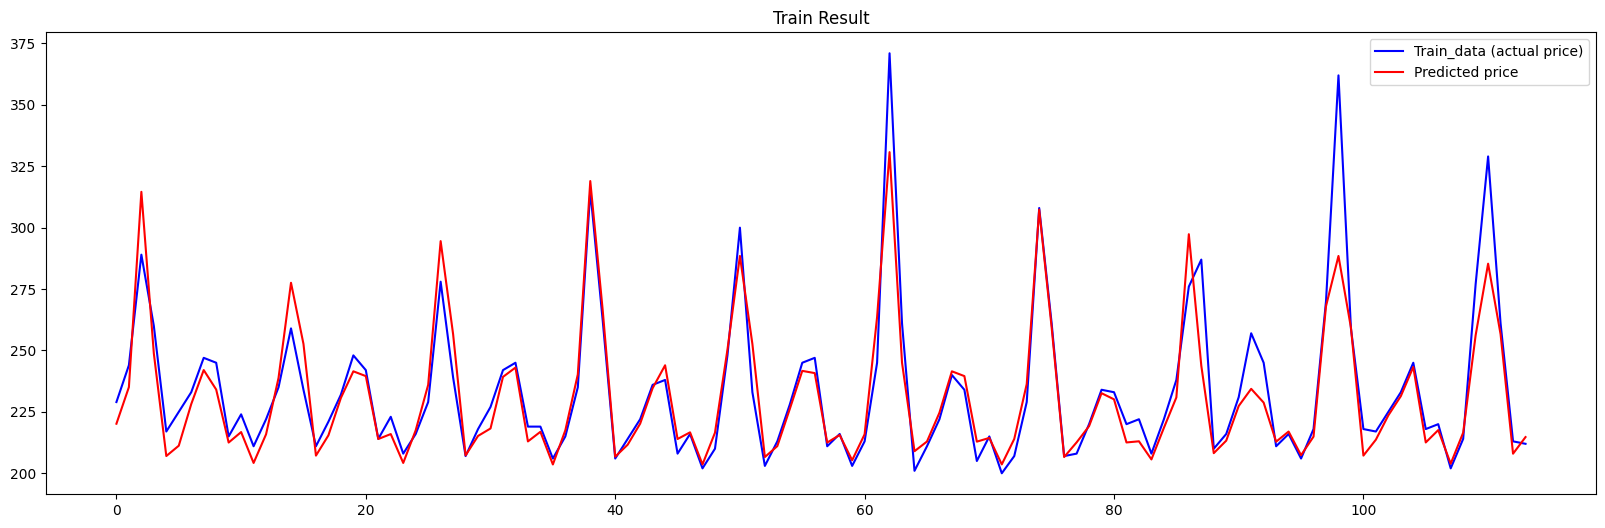

1/1 [==============================] - 0s 22ms/step


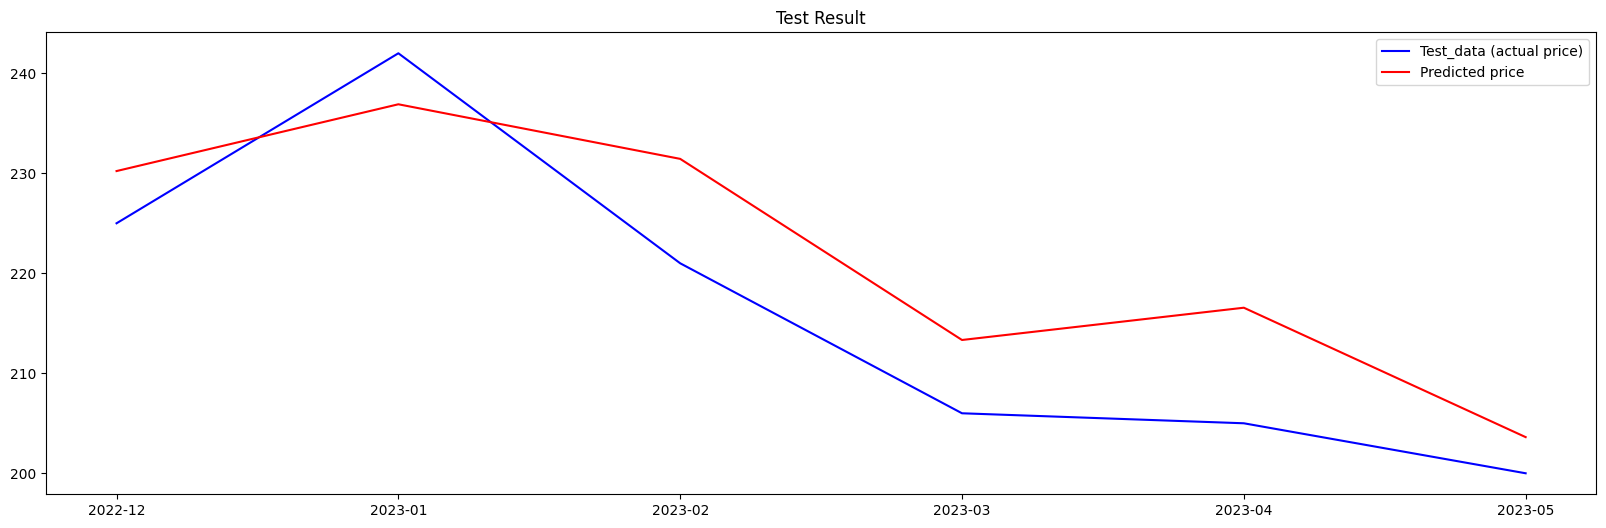

1/1 [==============================] - 0s 21ms/step
실제값 : 
[242. 221. 206. 205. 200.  nan  nan]
예측값 : 
[[236.8999 ]
 [231.44084]
 [213.32912]
 [216.55598]
 [203.61546]
 [216.85161]
 [230.31215]]


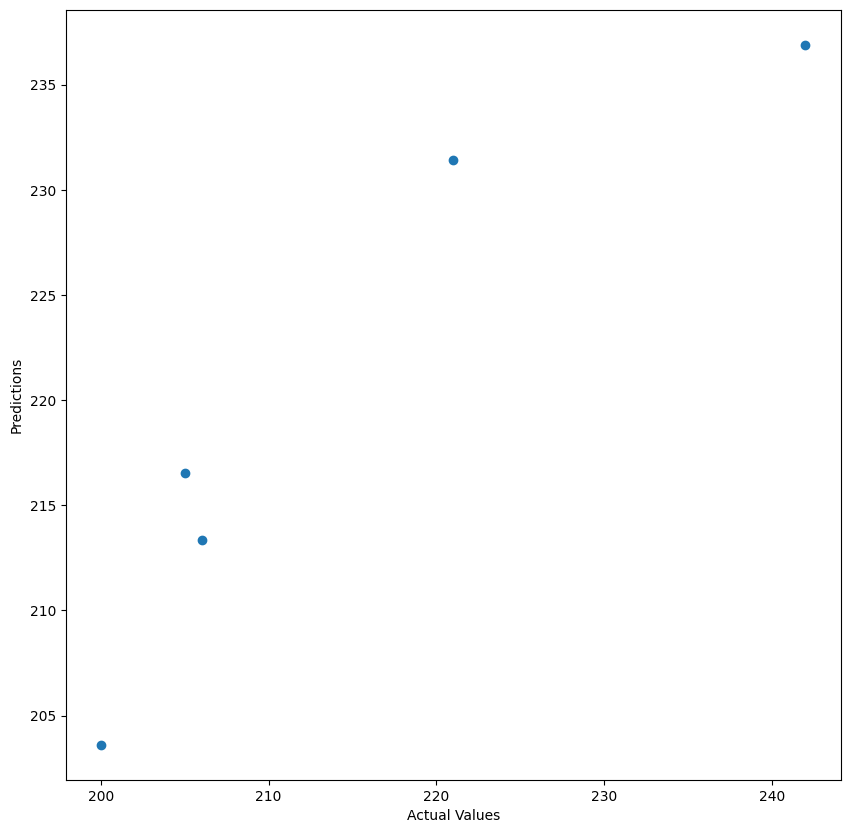

In [153]:
data_MLP1 = data1[:120]
data_MLP2 = data1[114:120]
data_MLP3 = data1[115:]

X = data_MLP1[['ATemp', 'month']].values
y = data_MLP1['kWH'].values

X_1 = data_MLP2[['ATemp', 'month']].values
y_1 = data_MLP2['kWH'].values

X_2 = data_MLP3[['ATemp', 'month']].values
y_2 = data_MLP3['kWH'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

model = Sequential()
model.add(Dense(64, activation='softmax', input_shape=(2,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

model.fit(X_train, y_train, epochs=10000, batch_size=32, verbose=1)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_loss = mean_absolute_error(y_train, y_train_pred)
test_loss = mean_absolute_error(y_test, y_test_pred)


print('Train mae:', train_loss)

print('Test mae:', test_loss)

fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)

ax.plot(y_train, c='b',label='Train_data (actual price)')
ax.plot(y_train_pred, c='r', label='Predicted price')
ax.legend()
plt.title('Train Result')
plt.show()



y_pred_1 = model.predict(X_1)
X_plt = ['2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05']
fig = plt.figure(facecolor='white', figsize=(20, 6))
ax = fig.add_subplot(111)

ax.plot(X_plt, y_1, c='b',label='Test_data (actual price)')
ax.plot(X_plt, y_pred_1, c='r', label='Predicted price')
ax.legend()
plt.title('Test Result')
plt.show()

y_pred_2 = model.predict(X_2)
print("실제값 : ")
print(y_2)
print("예측값 : ")
print(y_pred_2)
plt.figure(figsize=(10,10))
plt.scatter(y_2, y_pred_2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.show()

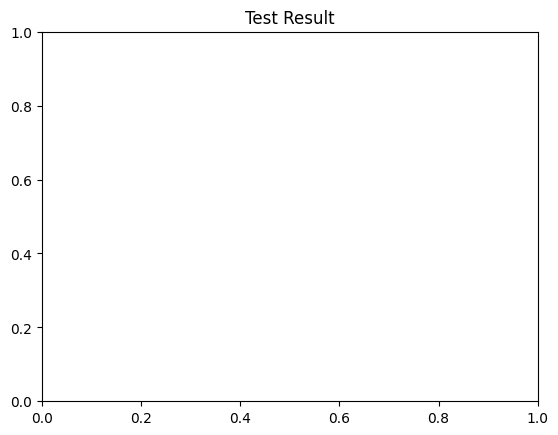

In [157]:
ax.plot(y_1, c='b',label='Test_data (actual value)')
ax.plot(y_pred_1, c='r', label='MLP value')
ax.plot(Y_test_pred, c='g', label='LSTM value')
ax.plot(fc_test, c='orange', label='ARIMA value')
ax.legend()
plt.title('Test Result')
plt.show()

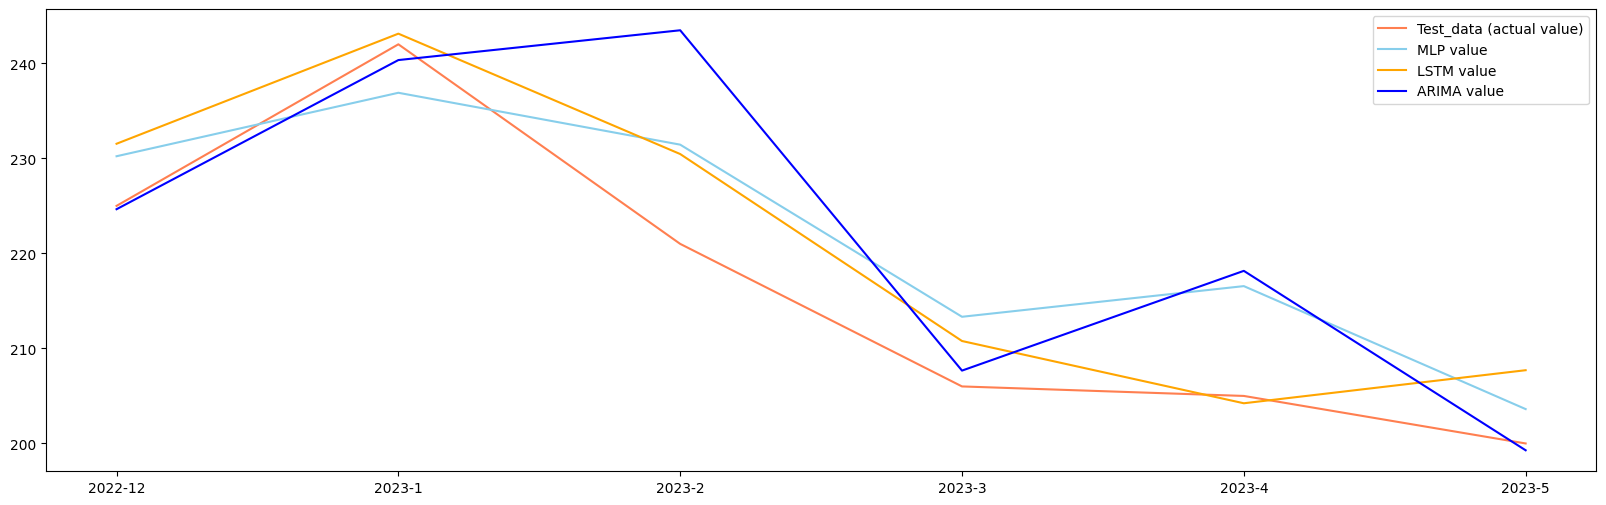

In [155]:
fig = plt.figure(facecolor='white', figsize=(20, 6))
X = ['2022-12', '2023-1', '2023-2', '2023-3', '2023-4', '2023-5']
plt.plot(X, y_1, color = '#FF7F50', label = 'Test_data (actual value)')
plt.plot(X, y_pred_1, color = 'skyblue', label='MLP value')
plt.plot(X, Y_test_pred, color = 'orange', label='LSTM value')
plt.plot(X, fc_test, color = 'blue', label='ARIMA value')
plt.legend()

In [156]:
pred_list = fc_test.to_list()
for i in range(2):
    pred_list.append(pred_to_list[i])
del pred_list[0]
pred_list

[240.34183343626236,
 243.47607748891534,
 207.66619847702515,
 218.16235703130005,
 199.2819847965215,
 215.7721342652385,
 265.0818099774599]

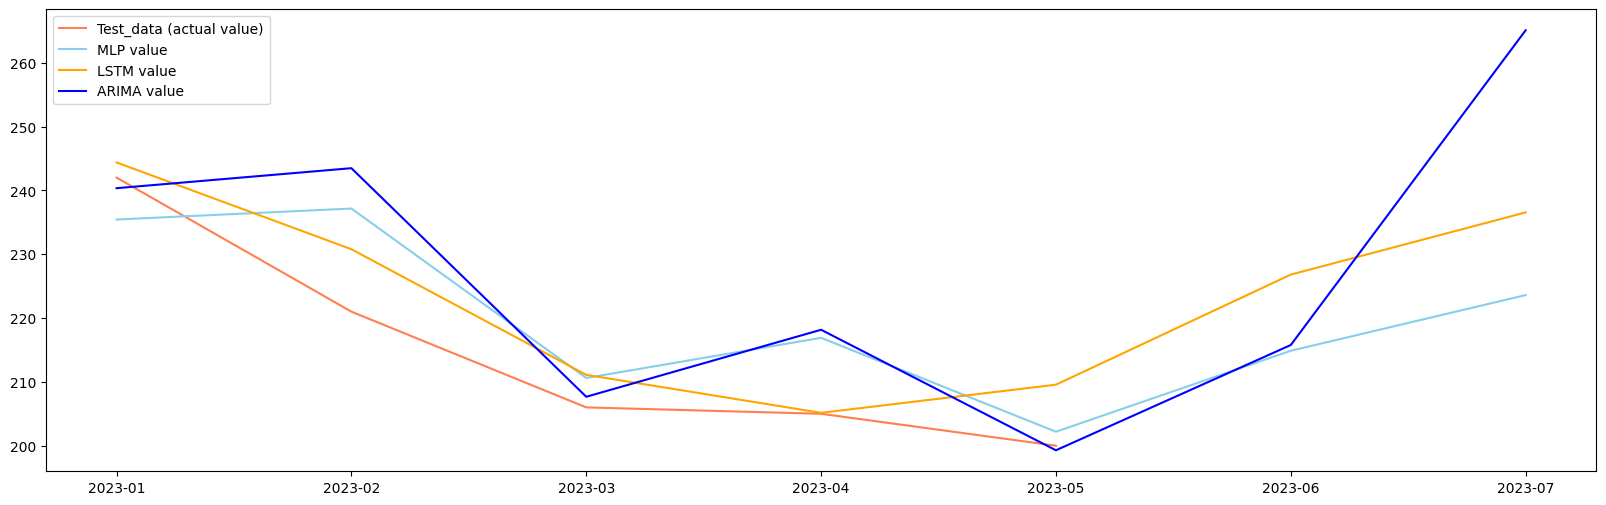

In [145]:
fig = plt.figure(facecolor='white', figsize=(20, 6))
X = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07']
plt.plot(X, y_2, color = '#FF7F50', label = 'Test_data (actual value)')
plt.plot(X, y_pred_2, color = 'skyblue', label='MLP value')
plt.plot(X, Y_new_pred, color = 'orange', label='LSTM value')
plt.plot(X, pred_list, color = 'blue', label='ARIMA value')
plt.legend()